In [53]:
%cd /content/drive/MyDrive/Github/Machine_Learning_personal_learning

/content/drive/MyDrive/Github/Machine_Learning_personal_learning


In [111]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2

In [55]:
# Importing the dataset
data_tr = pd.read_csv("../../ML_datasets/Crystal_Structure_Classification/train_dataset.csv")
data_tr.head()

,v(A),v(B),r(AXII)(Å),r(AVI)(Å),r(BVI)(Å),EN(A),EN(B),l(A-O)(Å),l(B-O)(Å),ΔENR,tG,τ,μ,Lowest distortion
0,0,0,0.52,0.52,0.93,2.18,2.54,2.214685,2.313698,-1.728214,0.582680,0.000000,0.664286,cubic
1,0,0,1.03,0.86,0.60,1.27,1.90,2.500930,0.000000,-1.768643,0.859135,0.000000,0.428571,cubic
2,2,4,0.92,0.67,0.53,1.83,1.88,2.290644,1.930311,-1.468464,0.849994,4.936558,0.378571,cubic
3,1,5,1.64,1.38,0.62,0.82,2.36,3.025719,1.745600,-1.974429,1.064161,3.977376,0.442857,orthorhombic
4,0,0,0.57,0.57,0.71,2.20,1.30,2.300109,2.027412,-1.622357,0.660190,0.000000,0.507143,cubic


array([[<Axes: title={'center': 'v(A)'}>,
        <Axes: title={'center': 'v(B)'}>,
        <Axes: title={'center': 'r(AXII)(Å)'}>,
        <Axes: title={'center': 'r(AVI)(Å)'}>],
       [<Axes: title={'center': 'r(BVI)(Å)'}>,
        <Axes: title={'center': 'EN(A)'}>,
        <Axes: title={'center': 'EN(B)'}>,
        <Axes: title={'center': 'l(A-O)(Å)'}>],
       [<Axes: title={'center': 'l(B-O)(Å)'}>,
        <Axes: title={'center': 'ΔENR'}>, <Axes: title={'center': 'tG'}>,
        <Axes: title={'center': 'τ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

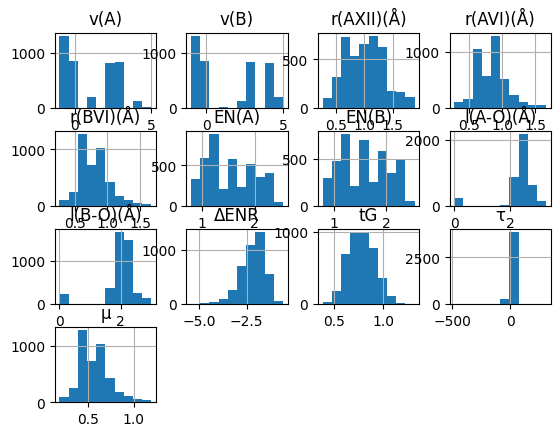

In [56]:
data_tr.hist()

In [130]:
# Assigning X and Y: X - all features except last column of dataset, Y - One hot encoding of classification column (final column of dataset)
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(data_tr[["Lowest distortion"]])
Y = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out(['Lowest distortion']))
X = data_tr.drop(columns = ["Lowest distortion"])
Y.head()

,Lowest distortion_cubic,Lowest distortion_orthorhombic,Lowest distortion_rhombohedral,Lowest distortion_tetragonal
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [134]:
# convert y to one d array where each row is a 1-D array of hot encoded features
#Y['Lowest distortion'] = Y.apply(lambda row: [row['Lowest distortion_cubic'], row['Lowest distortion_orthorhombic'], row['Lowest distortion_rhombohedral'], row['Lowest distortion_tetragonal']], axis=1)
#Y = Y['Lowest distortion']
y_labels = np.argmax(Y, axis=1)
#y_labels[0:30]
Y = y_labels

In [59]:
# Find correlations between features in X in abs scale
corr_matrix = X.corr().abs()
# print(corr_matrix["r(BVI)(Å)"], corr_matrix["μ"], corr_matrix["r(AVI)(Å)"], corr_matrix["r(AXII)(Å)"])
# corr_matrix = corr_matrix.mask(np.eye(corr_matrix.shape[0], dtype=bool))
corr_series = corr_matrix.unstack()
corr_series = corr_series.sort_values(ascending = False)
corr_series = corr_series.drop_duplicates()
# print(corr_series[0:10])

# plotting correlation matrix
fig = px.imshow(corr_matrix, text_auto = True)
fig.show()

# plotting between 2 correlations
fig = px.scatter(x = corr_matrix["r(AVI)(Å)"], y = corr_matrix["r(AXII)(Å)"], labels = {"x": "r(AVI)(Å)", "y": "r(AXII)(Å)"})
fig.show()

In [60]:
# Performing transformations on X's features
#X_log = X.copy()
#X_log = np.log(X + 1)
#X_log.head()

array([[<Axes: title={'center': 'v(A)'}>,
        <Axes: title={'center': 'v(B)'}>,
        <Axes: title={'center': 'r(AXII)(Å)'}>,
        <Axes: title={'center': 'r(AVI)(Å)'}>],
       [<Axes: title={'center': 'r(BVI)(Å)'}>,
        <Axes: title={'center': 'EN(A)'}>,
        <Axes: title={'center': 'EN(B)'}>,
        <Axes: title={'center': 'l(A-O)(Å)'}>],
       [<Axes: title={'center': 'l(B-O)(Å)'}>,
        <Axes: title={'center': 'ΔENR'}>, <Axes: title={'center': 'tG'}>,
        <Axes: title={'center': 'τ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

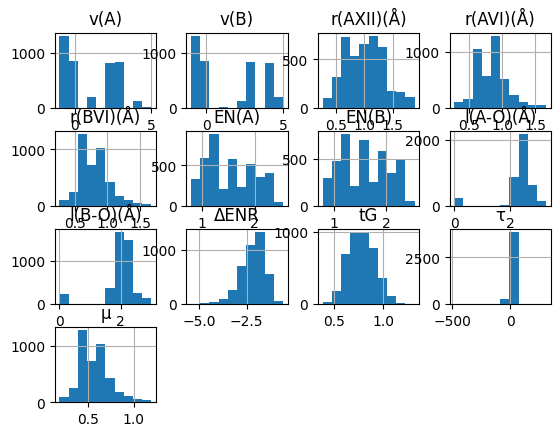

In [61]:
X.hist()

In [62]:
#X_log.hist()

In [63]:
# Preprocessing X using strandard scalar (X - \mu/ \sigma)
scalar = StandardScaler()
X_c = X.copy()
X = pd.DataFrame(scalar.fit_transform(X_c), columns = X_c.columns)

# can drop either "μ" or "r(BVI)(Å)" as their correlation value = 1 (selected "μ")
# can also deop either of "r(AVI)(Å)" or "r(AXII)(Å)" as their correlation value ~ 0.93 (future work)
X = X.drop(columns = ["μ"])

array([[<Axes: title={'center': 'v(A)'}>,
        <Axes: title={'center': 'v(B)'}>,
        <Axes: title={'center': 'r(AXII)(Å)'}>],
       [<Axes: title={'center': 'r(AVI)(Å)'}>,
        <Axes: title={'center': 'r(BVI)(Å)'}>,
        <Axes: title={'center': 'EN(A)'}>],
       [<Axes: title={'center': 'EN(B)'}>,
        <Axes: title={'center': 'l(A-O)(Å)'}>,
        <Axes: title={'center': 'l(B-O)(Å)'}>],
       [<Axes: title={'center': 'ΔENR'}>, <Axes: title={'center': 'tG'}>,
        <Axes: title={'center': 'τ'}>]], dtype=object)

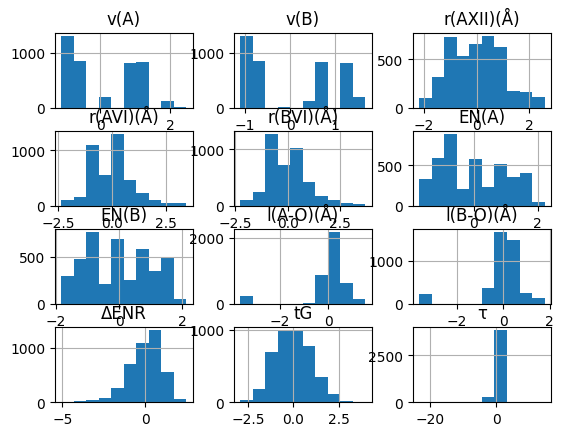

In [64]:
X.hist()

In [65]:
# We will use stratified k-fold cross validation to train the models
# setting accuracy score as scoring metric for k-fold
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

# Initializing models to be used
models = {
    "SVC": SVC(),
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=18),
    "GradientBoosting": GradientBoostingClassifier(random_state=18),
    "Bagging": BaggingClassifier(),
    "ExtraTrees": ExtraTreesClassifier(random_state=18),
    "KNeighbors": KNeighborsClassifier()
    }

In [66]:
# k = 5 splits
scores_k5 = []
times_k5 = []

# Producing cross validation score and runtime for the models and tabulationg them in a table
for i in models:
  model = models[i]
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # k = 5 splits
  start_time = time.time()
  scores = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = cv_scoring)
  end_time = time.time()
  execution_time = end_time - start_time
  scores_k5.append(np.mean(scores))
  times_k5.append(execution_time)
  print("=="*30)
  print(i)
  print(f"Scores: {scores}")
  print(f"Mean Score: {np.mean(scores)}")
  print(f"Model training time: {execution_time} seconds")


SVC
Scores: [0.71188475 0.71548619 0.71548619 0.71668667 0.727491  ]
Mean Score: 0.7174069627851141
Model training time: 6.742882013320923 seconds
GaussianNB
Scores: [0.53781513 0.53421369 0.54741897 0.58223289 0.55462185]
Mean Score: 0.5512605042016807
Model training time: 0.061809539794921875 seconds
RandomForest
Scores: [0.78991597 0.80792317 0.77671068 0.79951981 0.80792317]
Mean Score: 0.7963985594237695
Model training time: 5.17754864692688 seconds
GradientBoosting
Scores: [0.75870348 0.78151261 0.7334934  0.757503   0.77070828]
Mean Score: 0.7603841536614646
Model training time: 18.706326484680176 seconds
Bagging
Scores: [0.7635054  0.79231693 0.76230492 0.77671068 0.78511405]
Mean Score: 0.7759903961584633
Model training time: 0.9458167552947998 seconds
ExtraTrees
Scores: [0.79111645 0.79591837 0.75270108 0.78991597 0.80072029]
Mean Score: 0.7860744297719087
Model training time: 2.5758461952209473 seconds
KNeighbors
Scores: [0.73829532 0.74429772 0.72028812 0.75270108 0.7394958

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}
XGBoostClassifier
0      0.724370
1      0.737815
2      0.745258
3      0.748860
4      0.750780
         ...   
195    0.797839
196    0.798559
197    0.798559
198    0.798079
199    0.798079
Name: test-merror-mean, Length: 200, dtype: float64
Mean Sc

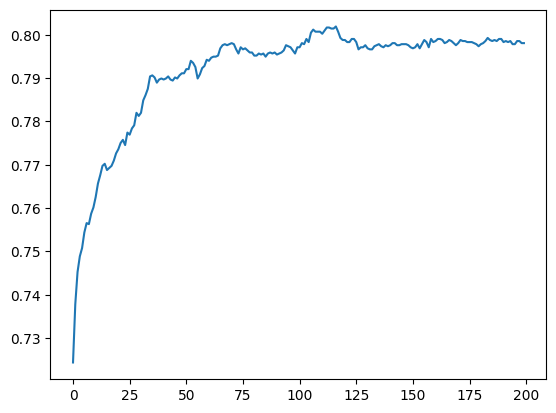

In [67]:
# for XGBoost, remember scores here outputed from xgb.cv is from every boosted rounds
models["XGBoost"] = xgb.XGBClassifier(random_state=18, objective="multi:softmax", num_class=4)
start_time = time.time()
dtrain = xgb.DMatrix(X, Y)
params = models["XGBoost"].get_xgb_params()
print(params)
cv_results = xgb.cv(params = params, dtrain = dtrain, nfold = 5, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 200)
end_time = time.time()
execution_time = end_time - start_time
scores = 1 - cv_results["test-merror-mean"]
print("=="*30)
print("XGBoostClassifier")
print(scores)
print(f"Mean Score: {scores[len(scores) - 1]}")
scores_k5.append(scores[len(scores) - 1])
times_k5.append(execution_time)
print(f"Model training time: {execution_time} seconds")
plt.plot(scores)
plt.show()

For k = 5, based on cross_val_score and runtime on the entire training dataset, top 5 performing models are RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, KNeighborsClassifier, XGBoostClassifier. GradientBoosting performs better than KNeighborsClassifer, however takes 50 times more time so not selected.

In [68]:
# k = 10 splits
scores_k10 = []
times_k10 = []
for i in models:
  if i == "XGBoost":
    continue
  model = models[i]
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # k = 10 splits
  start_time = time.time()
  scores = cross_val_score(model, X, Y, cv = cv, n_jobs = -1, scoring = cv_scoring)
  end_time = time.time()
  execution_time = end_time - start_time
  scores_k10.append(np.mean(scores))
  times_k10.append(execution_time)
  print("=="*30)
  print(i)
  print(f"Scores: {scores}")
  print(f"Mean Score: {np.mean(scores)}")
  print(f"Model training time: {execution_time} seconds")

SVC
Scores: [0.69544365 0.72661871 0.71942446 0.71942446 0.69304556 0.73798077
 0.73557692 0.70673077 0.74519231 0.71394231]
Mean Score: 0.7193379911455451
Model training time: 5.109938621520996 seconds
GaussianNB
Scores: [0.52517986 0.54196643 0.54916067 0.54676259 0.55395683 0.53125
 0.57451923 0.5625     0.56009615 0.55048077]
Mean Score: 0.5495872532743037
Model training time: 0.08140325546264648 seconds
RandomForest
Scores: [0.8177458  0.79616307 0.80095923 0.83693046 0.7529976  0.76923077
 0.82451923 0.78605769 0.82692308 0.82451923]
Mean Score: 0.8036046163069545
Model training time: 9.585396766662598 seconds
GradientBoosting
Scores: [0.77218225 0.7529976  0.77697842 0.79136691 0.71702638 0.74278846
 0.77403846 0.75480769 0.79326923 0.75480769]
Mean Score: 0.7630263097214536
Model training time: 33.79417538642883 seconds
Bagging
Scores: [0.79616307 0.77458034 0.7793765  0.82014388 0.72901679 0.75240385
 0.81009615 0.77403846 0.79807692 0.80288462]
Mean Score: 0.7836780575539569


{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 18, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 4}
XGBoostClassifier
0     0.737331
1     0.746703
2     0.752229
3     0.751987
4     0.754389
        ...   
70    0.806486
71    0.804807
72    0.804566
73    0.805286
74    0.805286
Name: test-merror-mean, Length: 75, dtype: float64
Mean Score: 0.80528

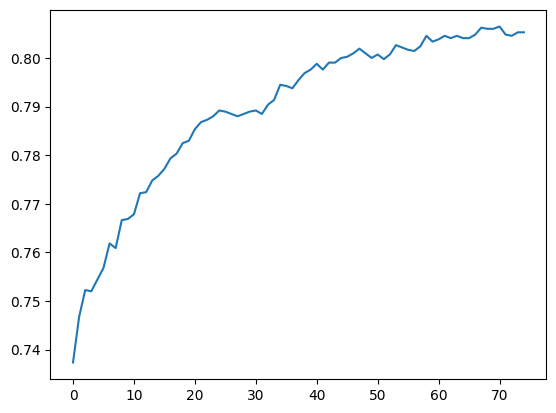

In [69]:
# for XGBoost, using nfolds = 10 and num_boost round = 75
start_time = time.time()
dtrain = xgb.DMatrix(X, Y)
params = models["XGBoost"].get_xgb_params()
print(params)
cv_results = xgb.cv(params = params, dtrain = dtrain, nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
end_time = time.time()
execution_time = end_time - start_time
scores = 1 - cv_results["test-merror-mean"]
scores_k10.append(scores[len(scores) - 1])
times_k10.append(execution_time)
print("=="*30)
print("XGBoostClassifier")
print(scores)
print(f"Mean Score: {scores[len(scores) - 1]}")
print(f"Model training time: {execution_time} seconds")
plt.plot(scores)
plt.show()

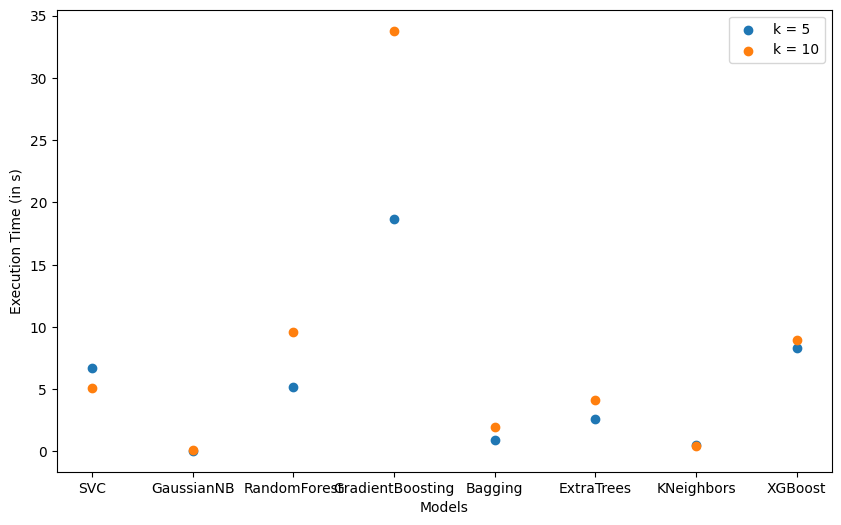

In [70]:
# plotting time comparison between nfolds = 5 and nfolds = 10 for all models in one plot appropriately sizing x an y labels so that they do not overlap
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), times_k5)
plt.scatter(models.keys(), times_k10)
plt.legend(["k = 5", "k = 10"])
plt.xlabel("Models")
plt.ylabel("Execution Time (in s)")
plt.show()

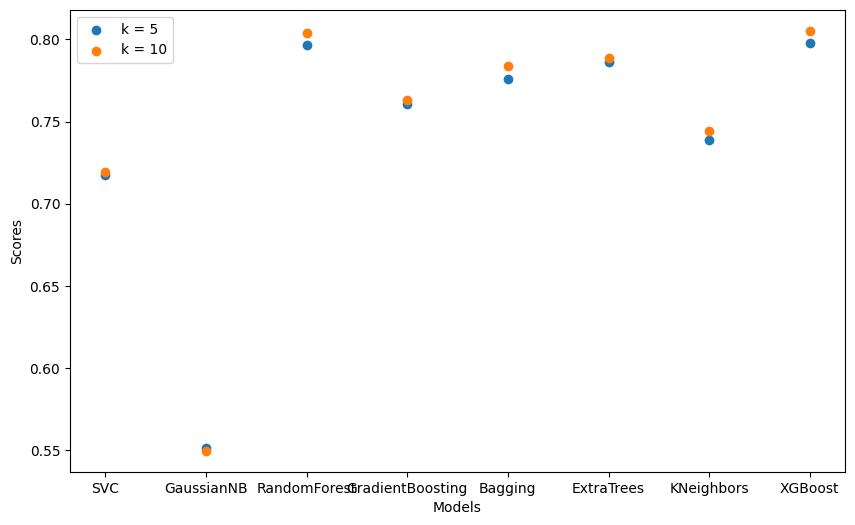

In [71]:
# plotting scores comparison between nfolds = 5 and nfolds = 10 for all models in one plot appropriately sizing x an y labels so that they do not overlap
plt.figure(figsize=(10, 6))
plt.scatter(models.keys(), scores_k5)
plt.scatter(models.keys(), scores_k10)
plt.legend(["k = 5", "k = 10"])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.show()

For k = 10, based on cross_val_score and runtime on the entire training dataset, top 5 performing models remain the same as that obtained for k = 5, however the training time doubles and very little increase in scores is observed. A key observation is that XGBoost becomes the best model.

On incresing k-folds from 5 to 10, BaggingClassifier, KNeighborsClassifier and XGBoostClassifier do not show significant increase in execution times than other algorithms. Furthermore, BaggingClassifier, ExtraTreesClassifier and XGBoostClassifier show more significant improvements in accuracy score than other algorithms. So we use k-folds = 10 for these models.

We will use the 4 models and try to perform hyperparameter tuning to try to improve the model performance

In [135]:
# splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 24)

# splitting the training set further to get a cross_validation set
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.25, random_state = 24)

# printing...
print(f"Train: {X_train.shape}, {y_train.shape}")
#print(f"Train: {X_cv.shape}, {y_cv.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (3332, 13), (3332,)
Test: (833, 13), (833,)


In [73]:
# Model 1: RandomForestClassifier
model_RFC = RandomForestClassifier(random_state=18, n_jobs = -1)
print(model_RFC.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
# Create the GridSearchCV object
grid_search_RFC = GridSearchCV(model_RFC, param_grid, cv=5, scoring='accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_RFC.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_RFC = pd.DataFrame(grid_search_RFC.cv_results_)
print(grid_search_RFC.best_params_)
# Print the best score
print(grid_search_RFC.best_score_)
# Get the best model
best_model = grid_search_RFC.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross validation set:")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 18, 'verbose': 0, 'warm_start': False}
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
0.7914151032591812
Results for Cross validation set:
Accuracy Score: 0.7887154861944778
Precision Score: 0.6628173800696551
Recall Score: 0.5283650397356814
F1 Score: 0.564715850452516
Model training time: 102.92371439933777 seconds


In [74]:
# Model 2: BaggingClassifier
model_BC = BaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs = -1)
print(model_BC.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_samples': [0.03, 0.1, 0.3, 1.0],
    'max_features': [0.5, 1.0],
    'estimator__max_depth': [2, 5, 10, 20]
}
# Create the GridSearchCV object
grid_search_BC = GridSearchCV(model_BC, param_grid, cv=10, scoring='accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_BC.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_BC = pd.DataFrame(grid_search_BC.cv_results_)
print(grid_search_BC.best_params_)
# Print the best score
print(grid_search_BC.best_score_)
# Get the best model
best_model = grid_search_BC.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'estimator__max_depth': 20, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
0.795919871967776
Results for Cross-validation set
Accuracy Score: 0.7995198079231692
Precision Score: 0.6739720578408145
Recall Score: 0.5701656418270886
F1 Score: 0.6053301283089447
Model training time: 187.73458218574524 se

In [75]:
# Model 3: KNeighborsClassifier
model_KN = KNeighborsClassifier(n_jobs = -1)
print(model_BC.get_params())
# hyperparameter optimization using GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_neighbors' : [2, 3, 5, 8, 10, 13, 15, 18, 25],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}
# Create the GridSearchCV object
grid_search_KN = GridSearchCV(model_KN, param_grid, cv=10, scoring='accuracy')
start_time = time.time()
# Fit the grid search to the data
grid_search_KN.fit(X_train, y_train)
# Store the results in a pandas dataframe
gs_KN = pd.DataFrame(grid_search_KN.cv_results_)
print(grid_search_KN.best_params_)
# Print the best score
print(grid_search_KN.best_score_)
# Get the best model
best_model = grid_search_KN.best_estimator_
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
0.7775979572386758
Results for Cross-validation set
Accuracy Score: 0.7755102040816326
Precision Score: 0.6443947808886183
Recall Score: 0.5517641995125259
F1 Score: 0.5833772953682886
Model training time: 24.213611602783203 seconds


In [93]:
# Model 4: XGBoostClassifier: here since we have a large number of hyperparameters to tune, we will perform step by step tuning
# Step 1: Random initialization
# Define first stage hyperparameter grid
param_grid = {
    'max_depth' : [3, 5],
    'learning_rate': [0.01, 0.1, 1],
    'min_child_weight' : [1, 5],
    'gamma' : [0, 0.3, 1],
    'colsample_bytree': [0.3, 1.0],
    'reg_lambda' : [0.5, 1.0],
    'subsample' : [0.5, 1.0]
}
best_score = 0
start_time = time.time()
# Fit the grid search to the data
for params in itertools.product(*param_grid.values()):
   params_dict = dict(zip(param_grid.keys(), params))
   params_dict["num_class"] = 4
   params_dict["random_state"] = 18
   params_dict["objective"] = "multi:softmax"
   cv_results = xgb.cv(params = params_dict, dtrain = xgb.DMatrix(X_train, label = y_train), nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
#grid_search_XG.fit(X_train, y_train)
# Store the results in a pandas dataframe
   scores = 1 - cv_results["test-merror-mean"]
   print(f"Scores: {scores[len(scores) - 1]}, Parameters: {params_dict})")
   if scores[len(scores) - 1] > best_score:
      best_score = scores[len(scores) - 1]
      best_params = dict(zip(param_grid.keys(), params))
print(best_params)
# Print the best score
print(best_score)
# Get the best model
best_model = xgb.XGBClassifier(**best_params, random_state = 18, objective="multi:softmax", num_class = 4, n_estimators = 75)
best_model.fit(X_train, y_train)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

Scores: 0.7076684468900037, Parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 0.3, 'reg_lambda': 0.5, 'subsample': 0.5, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.706772940605276, Parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 0.3, 'reg_lambda': 0.5, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7076693459926993, Parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 0.3, 'reg_lambda': 1.0, 'subsample': 0.5, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7070723418028808, Parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 0.3, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.719378360396324

From the first stage, we got the following tune parameters
{'max_depth': 5, 'learning_rate': 1, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}.
In the next step, we will try to optimize min_child_weight and max_tree_depth

In [96]:
# Step 2: Optimize max_depth and min_child_weight keeping other paramters same from Step 1:
param_grid = {
    'max_depth' : [5, 10, 15, 20],
    'learning_rate': [1],
    'min_child_weight' : [1, 3, 5, 7],
    'gamma' : [0],
    'colsample_bytree': [1.0],
    'reg_lambda' : [1.0],
    'subsample' : [1.0]
}
best_score = 0
start_time = time.time()
# Fit the grid search to the data
for params in itertools.product(*param_grid.values()):
   params_dict = dict(zip(param_grid.keys(), params))
   params_dict["num_class"] = 4
   params_dict["random_state"] = 18
   params_dict["objective"] = "multi:softmax"
   cv_results = xgb.cv(params = params_dict, dtrain = xgb.DMatrix(X_train, label = y_train), nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
#grid_search_XG.fit(X_train, y_train)
# Store the results in a pandas dataframe
   scores = 1 - cv_results["test-merror-mean"]
   print(f"Scores: {scores[len(scores) - 1]}, Parameters: {params_dict})")
   if scores[len(scores) - 1] > best_score:
      best_score = scores[len(scores) - 1]
      best_params = dict(zip(param_grid.keys(), params))
print(best_params)
# Print the best score
print(best_score)
# Get the best model
best_model = xgb.XGBClassifier(**best_params, random_state = 18, objective="multi:softmax", num_class = 4, n_estimators = 75)
best_model.fit(X_train, y_train)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

Scores: 0.7965141788495081, Parameters: {'max_depth': 5, 'learning_rate': 1, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7974240707773642, Parameters: {'max_depth': 5, 'learning_rate': 1, 'min_child_weight': 3, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7962102821384258, Parameters: {'max_depth': 5, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7935138731545918, Parameters: {'max_depth': 5, 'learning_rate': 1, 'min_child_weight': 7, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7977162791534049, Paramete

From the second stage, we got the following tune parameters
{'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}.
In the next step, we will try to optimize gamma

In [97]:
# Step 3: Optimize gamma keeping other paramters same from Step 2:
param_grid = {
    'max_depth' : [20],
    'learning_rate': [1],
    'min_child_weight' : [5],
    'gamma' : [0, 0.1, 0.3, 0.5, 0.7, 1],
    'colsample_bytree': [1.0],
    'reg_lambda' : [1.0],
    'subsample' : [1.0]
}
best_score = 0
start_time = time.time()
# Fit the grid search to the data
for params in itertools.product(*param_grid.values()):
   params_dict = dict(zip(param_grid.keys(), params))
   params_dict["num_class"] = 4
   params_dict["random_state"] = 18
   params_dict["objective"] = "multi:softmax"
   cv_results = xgb.cv(params = params_dict, dtrain = xgb.DMatrix(X_train, label = y_train), nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
#grid_search_XG.fit(X_train, y_train)
# Store the results in a pandas dataframe
   scores = 1 - cv_results["test-merror-mean"]
   print(f"Scores: {scores[len(scores) - 1]}, Parameters: {params_dict})")
   if scores[len(scores) - 1] > best_score:
      best_score = scores[len(scores) - 1]
      best_params = dict(zip(param_grid.keys(), params))
print(best_params)
# Print the best score
print(best_score)
# Get the best model
best_model = xgb.XGBClassifier(**best_params, random_state = 18, objective="multi:softmax", num_class = 4, n_estimators = 75)
best_model.fit(X_train, y_train)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

Scores: 0.8016237794680908, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7911150671629714, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0.1, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7929132725539911, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0.3, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7809129488770208, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0.5, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7761018503533473

From the third stage, we got the following tune parameters {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}. In the next step, we will try to optimize sample and colsample_bytree

In [98]:
# Step 4: Optimize subsample and colsample_bytree keeping other paramters same from Step 3:
param_grid = {
    'max_depth' : [20],
    'learning_rate': [1],
    'min_child_weight' : [5],
    'gamma' : [0],
    'colsample_bytree': [0.5, 0.6, 0.8, 1],
    'reg_lambda' : [1.0],
    'subsample' : [0.5, 0.6, 0.8, 1.0]
}
best_score = 0
start_time = time.time()
# Fit the grid search to the data
for params in itertools.product(*param_grid.values()):
   params_dict = dict(zip(param_grid.keys(), params))
   params_dict["num_class"] = 4
   params_dict["random_state"] = 18
   params_dict["objective"] = "multi:softmax"
   cv_results = xgb.cv(params = params_dict, dtrain = xgb.DMatrix(X_train, label = y_train), nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
#grid_search_XG.fit(X_train, y_train)
# Store the results in a pandas dataframe
   scores = 1 - cv_results["test-merror-mean"]
   print(f"Scores: {scores[len(scores) - 1]}, Parameters: {params_dict})")
   if scores[len(scores) - 1] > best_score:
      best_score = scores[len(scores) - 1]
      best_params = dict(zip(param_grid.keys(), params))
print(best_params)
# Print the best score
print(best_score)
# Get the best model
best_model = xgb.XGBClassifier(**best_params, random_state = 18, objective="multi:softmax", num_class = 4, n_estimators = 75)
best_model.fit(X_train, y_train)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

Scores: 0.7890156623689558, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.5, 'reg_lambda': 1.0, 'subsample': 0.5, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7842081602560644, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.5, 'reg_lambda': 1.0, 'subsample': 0.6, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7878162593731456, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7887126647605689, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.5, 'reg_lambda': 1.0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7845075614536692, Para

From the fourth stage, we got the following tune parameters {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.6, 'reg_lambda': 1.0, 'subsample': 1.0}. In the next step, we will try to optimize lambda

In [100]:
# Step 5: Optimize lambda keeping other paramters same from Step 4:
param_grid = {
    'max_depth' : [20],
    'learning_rate': [1],
    'min_child_weight' : [5],
    'gamma' : [0],
    'colsample_bytree': [0.6],
    'reg_lambda' : [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
    'subsample' : [1.0]
}
best_score = 0
start_time = time.time()
# Fit the grid search to the data
for params in itertools.product(*param_grid.values()):
   params_dict = dict(zip(param_grid.keys(), params))
   params_dict["num_class"] = 4
   params_dict["random_state"] = 18
   params_dict["objective"] = "multi:softmax"
   cv_results = xgb.cv(params = params_dict, dtrain = xgb.DMatrix(X_train, label = y_train), nfold = 10, stratified = True, metrics="merror", as_pandas = True, seed = 42, num_boost_round = 75)
#grid_search_XG.fit(X_train, y_train)
# Store the results in a pandas dataframe
   scores = 1 - cv_results["test-merror-mean"]
   print(f"Scores: {scores[len(scores) - 1]}, Parameters: {params_dict})")
   if scores[len(scores) - 1] > best_score:
      best_score = scores[len(scores) - 1]
      best_params = dict(zip(param_grid.keys(), params))
print(best_params)
# Print the best score
print(best_score)
# Get the best model
best_model = xgb.XGBClassifier(**best_params, random_state = 18, objective="multi:softmax", num_class = 4, n_estimators = 75)
best_model.fit(X_train, y_train)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

Scores: 0.793812375249501, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.6, 'reg_lambda': 0, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7950135764507023, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.6, 'reg_lambda': 0.001, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7944156731581882, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.6, 'reg_lambda': 0.003, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7938177698656741, Parameters: {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.6, 'reg_lambda': 0.01, 'subsample': 1.0, 'num_class': 4, 'random_state': 18, 'objective': 'multi:softmax'})
Scores: 0.7920123716530902, Pa

From the fifth stage, we got the following tune parameters {'max_depth': 20, 'learning_rate': 1, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 0.6, 'reg_lambda': 1.0, 'subsample': 1.0}.

Summary of performances of all the decision trees:


*   RandomForestClassifier: Training Accuracy = 0.791 || CV Accuracy = 0.789
*   BaggingClassifier: Training Accuracy = 0.796 || CV Accuracy = 0.800
*   KNeighborsClassifier: Training Accuracy = 0.777 || CV Accuracy = 0.776
*   XGBoostClassifier: Training Accuracy = 0.802 || CV Accuracy = 0.786


Out of all the decision trees implemented, BaggingClassifier had the best performance

In [137]:
# Fitting a neural network on the training dataset
# splitting the training set further to get a cross_validation set
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.25, random_state = 24)
start_time = time.time()
tf.random.set_seed(1234) # to ensure consistent results
model_nn = Sequential(
    [
        #input_shape = (X_train.shape[1],),
        Dense(60, activation = 'relu', name = "L1", kernel_regularizer = L2(0.01)),
        Dense(40, activation = 'relu', name = "L2", kernel_regularizer = L2(0.01)),
        Dense(20, activation = 'relu', name = "L3", kernel_regularizer = L2(0.01)),
        Dense(10, activation = 'relu', name = "L4", kernel_regularizer = L2(0.01)),
        Dense(4, activation = 'linear', name = "L5")
    ])
model_nn.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])
model_nn.summary()
history = model_nn.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_cv, y_cv))
y_pred = np.argmax(model_nn.predict(X_test), axis = 1)
end_time = time.time()
execution_time = end_time - start_time
ts_as = accuracy_score(y_test, y_pred)
ts_ps = precision_score(y_test, y_pred, average='macro')
ts_rs = recall_score(y_test, y_pred, average='macro')
ts_fs = f1_score(y_test, y_pred, average='macro')
print("Results for Cross-validation set")
print(f"Accuracy Score: {ts_as}")
print(f"Precision Score: {ts_ps}")
print(f"Recall Score: {ts_rs}")
print(f"F1 Score: {ts_fs}")
print(f"Model training time: {execution_time} seconds")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ L1 (Dense)                           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L2 (Dense)                           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L3 (Dense)                           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L4 (Dense)                           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L5 (Dense)                           │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4661 - loss: 2.3592 - val_accuracy: 0.5664 - val_loss: 1.8308
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5966 - loss: 1.7746 - val_accuracy: 0.5872 - val_loss: 1.6361
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6209 - loss: 1.5984 - val_accuracy: 0.6112 - val_loss: 1.5204
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6398 - loss: 1.4940 - val_accuracy: 0.6112 - val_loss: 1.4409
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6422 - loss: 1.4194 - val_accuracy: 0.6112 - val_loss: 1.3850
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6403 - loss: 1.3654 - val_accuracy: 0.6112 - val_loss: 1.3390
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6370 - loss: 1.3222 - val_accuracy: 0.6112 - val_loss: 1.3049
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6394 - loss: 1.2909 - val_accuracy: 0.6144 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



We get a very poor accuracy from the trained Neural Network Model (0.650)

Next learning Task: Need to learn how to tune the hyperparameters of Neural Network to improve its performance